# Data exploration & feature engineering

In [1]:
from collections import Counter
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load('en_core_web_md')

from config import TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE, N_GRAM
from helper import load_data

pd.set_option('max_colwidth', 120)

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, jus...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and ...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on,...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


## Data distribution

[15294, 1595, 8449, 478, 7877, 1405, 143346]


<BarContainer object of 6 artists>

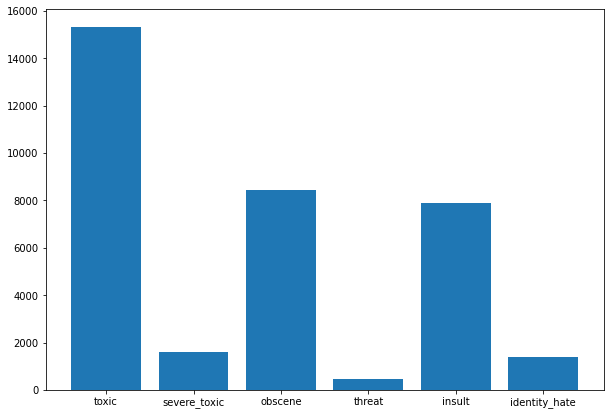

In [4]:
labels = df.columns[2:]
freqs = df[labels].sum(axis=0)

non_toxic = df[labels].sum(axis=1) == 0

# Frequencies including non-toxic comments
print(list(freqs) + [non_toxic.sum()])

plt.figure(figsize=(10, 7))
plt.bar(labels, freqs)

### Resampling dataset

As shown above the dataset is highly unbalanced. Unfortunately, since the labels are correlated there are no simple algorithms to rebalance the dataset to equal number of instances per label. We can convert it to a multi-class problem then rebalance it but there are a total of 40 unique combinations of labels, and we don't have enough data to fit each combination. So instead we will just attempt to rebalance it manually as best as we can.

In [5]:
df_all = df.assign(non_toxic=non_toxic.astype(np.int))
X_, Y_ = df['comment_text'], df[df.columns[2:]]
Y = pd.DataFrame(columns=df.columns[2:], index=Y_.index)

In [6]:
# The threat labels contains only 478 instances so we use them all
Y = Y.combine_first(Y_[Y_['threat'] == 1])
Y = Y.combine_first(Y_[(Y_['identity_hate'] == 1) & (Y_['toxic'] == 0)])
Y = Y.combine_first(Y_[Y_['severe_toxic'] == 1].sample(n=1200, random_state=42))
Y = Y.combine_first(Y_[Y_['identity_hate'] == 1].sample(n=1200, random_state=42))
rebalanced_freqs = Y.sum(axis=0)
rebalanced_freqs

toxic            2400.0
severe_toxic     1271.0
obscene          1992.0
threat            478.0
insult           1995.0
identity_hate    1264.0
dtype: float64

<BarContainer object of 6 artists>

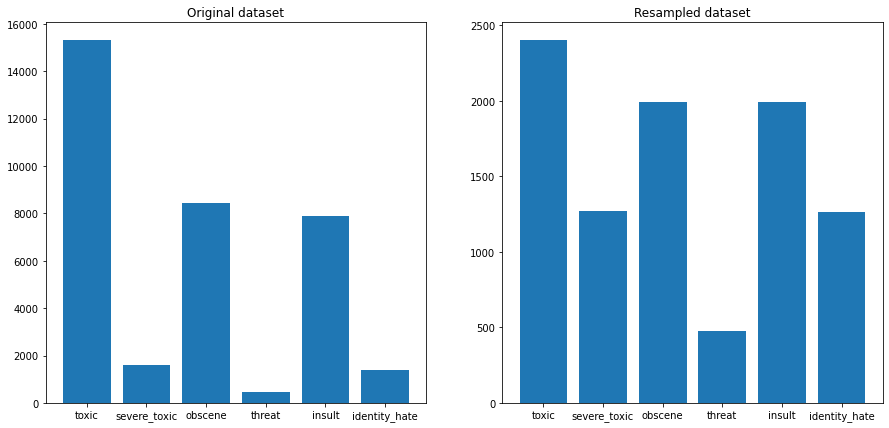

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.title.set_text('Original dataset')
ax1.bar(labels, freqs)
ax2.title.set_text('Resampled dataset')
ax2.bar(labels, rebalanced_freqs)

In [8]:
# Sample non toxic instances for the rest of the dataset
n_toxic = Y.dropna().shape[0]
n_target_total = TRAIN_SIZE + VALIDATION_SIZE + TEST_SIZE
non_toxic = Y_[Y_.sum(axis=1) == 0].sample(n=n_target_total - n_toxic, random_state=42)
Y = Y.combine_first(non_toxic)
Y.dropna(inplace=True)
X = X_[Y.index]

In [28]:
# Construct new (less imbalanced) dataset and serialize to disk
dataset = pd.DataFrame(data=X).merge(Y.astype(np.int), left_index=True, right_index=True)
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.to_pickle('train.pickle')

In [10]:
x_train, x_validation, x_test, y_train, y_validation, y_test = load_data()

## 1. Most and least common tokens

In [11]:
def tokens_generator(corpus):
    for text in corpus:
        doc = nlp(text)
        for token in doc:
            yield token.lemma_.lower()

tok_counter = Counter(tokens_generator(x_train))

In [12]:
# Tokens with the highest frequency
print(tok_counter.most_common(50))

[('-pron-', 30618), ('!', 15545), ('.', 14816), ('be', 14379), (',', 13329), ('the', 13052), ('"', 9192), ('to', 7720), ('a', 7082), ('and', 6436), ('of', 5588), ('fuck', 4858), ('not', 4018), ('in', 4009), ('that', 3876), ('\n\n', 3679), ('have', 3370), (' ', 3356), ('you', 3180), ('do', 3024), ('\n', 2986), ('for', 2707), ('this', 2554), ('-', 2512), ('nigger', 2438), ('on', 2211), (')', 2120), ('(', 2059), ('?', 1936), ('as', 1921), ('go', 1855), (':', 1838), ('will', 1736), ('with', 1665), ('if', 1621), ('article', 1610), ('fat', 1584), ('ass', 1485), ('wikipedia', 1440), ('suck', 1417), ('page', 1342), ('can', 1304), ('all', 1295), ('jew', 1282), ('but', 1228), ('u', 1209), ('or', 1172), ('die', 1170), ('an', 1099), ('cunt', 1056)]


In [13]:
# Number of tokens that only appear once
n_unary = list(tok_counter.values()).count(1)
n_unary

11301

In [14]:
word_freqs = pd.DataFrame(np.sort(np.array(list(tok_counter.values())))[::-1], columns=['freq'])
word_freqs.describe()

,freq
count,20257.000000
mean,20.690181
std,350.219735
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,30618.000000


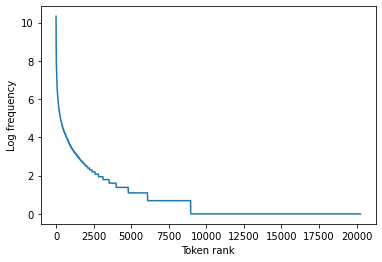

In [15]:
# Most words occurs very rarely
plt.xlabel('Token rank')
plt.ylabel('Log frequency')
plt.plot(range(word_freqs.size), np.log(word_freqs['freq']))

### Aggregate tokens between cutoff points for stopword/rare-word removal

We will retain informative tokens instead of removing most/least common tokens.

In [16]:
CUTOFF_HI = 500
CUTOFF_LO = 2

informative_tokens = set(
    map(lambda x: x[0],  # Get the token itself
        filter(lambda x: CUTOFF_LO <= x[1] < CUTOFF_HI,  # Filter predicate
               list(tok_counter.items()))))

# Write to disk for later use
with open('informative_tokens.pickle', 'wb') as f:
    pickle.dump(informative_tokens, f)

print(len(informative_tokens))

8851


## 2. N-gram

In [17]:
def n_gram_generator(corpus, n=2):
    for text in corpus:
        doc = nlp(text)
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha]
        if len(tokens) > n:
            for i in range(0, len(tokens) - n + 1):
                yield ' '.join(tokens[i:i+n])

n_gram_counter = Counter(n_gram_generator(x_train, N_GRAM))

In [18]:
n_gram_freqs = pd.DataFrame(np.sort(np.array(list(n_gram_counter.values())))[::-1], columns=['freq'])

# Number of bi-grams that occured more than once
n_gram_freqs[n_gram_freqs > 1].count()[0]

25772

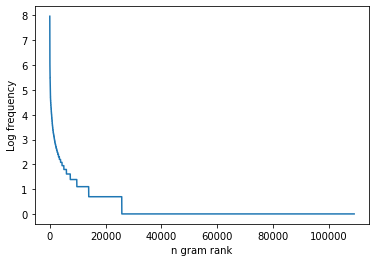

In [19]:
plt.xlabel('n gram rank')
plt.ylabel('Log frequency')
plt.plot(range(n_gram_freqs.size), np.log(n_gram_freqs['freq']))

In [20]:
print(n_gram_counter.most_common(10))

[('-pron- be', 2892), ('fuck -pron-', 1926), ('nigger nigger', 1720), ('be a', 1516), ('-pron- fuck', 1437), ('in the', 1392), ('jew fat', 1234), ('fat jew', 1226), ('-pron- have', 1128), ('of the', 1118)]


In [21]:
N_GRAM_CUTOFF_HI = 200
N_GRAM_CUTOFF_LO = 6

informative_ngrams = set(
    map(lambda x: x[0],  # Get the n_gram itself
        filter(lambda x: N_GRAM_CUTOFF_LO <= x[1] < N_GRAM_CUTOFF_HI,  # Filter predicate
               list(n_gram_counter.items()))))

# Write to disk for later use
import pickle
with open('informative_ngrams.pickle', 'wb') as f:
    pickle.dump(informative_ngrams, f)

print(len(informative_ngrams))

5794
